In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

In [2]:
fit_anti = False

In [3]:
exp = {'px_per_deg': 27,
      'N_trials': 400,
      'N_blocks': 1,
      'list_events': ['StimulusOn\n', 'StimulusOff\n',
                      'TargetOn\n', 'TargetOff\n']}

In [4]:
def moulti_fit(sujet, trial, max_step=14):
    
    if sujet < 13 : datafile = 'data/new_data/s%sBLa50.asc'%(sujet)
    else :          datafile = 'data/new_data/s%sBL50.asc'%(sujet)
    data_full = read_edf(datafile, 'Trialinfo')
    
    f = open('data/new_data/s%s_BL50_trials_errors.txt'%sujet, 'r')
    delete = f.read()
    delete = [[int(y) for y in x.split(' ')] for x in delete.split('\n') if x!='']
    list_trial = [delete[t][0]-1 for t in range(len(delete))]
    
    exp['dir_target'] = [[]]
    for t in range(len(list_trial)):
        if t not in list_trial : exp['dir_target'][0].append(None)
        else : exp['dir_target'][0].append([(abs(delete[x][1]-1)*2)-1 for x in range(len(list_trial)) if list_trial[x]==t][0])

    if [delete[t][2] for t in range(len(list_trial)) if list_trial[t]==trial][0] == 1 : print('Bad Trial')
    else : print('Good Trial')
    
    
    #=========================================================================================================
    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    #= 1 ===============================================================================================
    Plot.plot_fit(data_full, trials=trial, fig_width=30, plot_detail=None, fit_anticipation=fit_anti)

    arg = A.arg(data_full[trial], trial=trial, block=0)
    velocity = A.velocity_NAN(**arg)
    old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)
    rere = Fit.Fit_trial(velocity, value_latency=old_latency, value_steady_state=old_steady_state, value_anti=old_anti,
                         fit_anticipation=fit_anti, **arg)
    
    result_full_data = rere.values
    for k in ['latency', 'start_anti'] :
        result_full_data[k] = result_full_data[k] - (arg.TargetOn-arg.t_0)
    if fit_anti is False :
        del result_full_data['a_anti']
        del result_full_data['start_anti']
    
    #print('result_full_data =', result_full_data)

    #= 2 ===============================================================================================
    color = []
    for step in range(20) :
        color.append([])
        a = [0,0,0]
        a[step%3] = 0.15*(int(step/3)+1) #/(i+1)
        for i in range(step+2) :
            color[step].append(tuple(a))

    result_red_data = []

    N = len(velocity)
    for n, step in enumerate(np.arange(2, max_step)) :
        result_red_data.append([])
        for i in np.arange(step) :
            
            veve = np.copy(velocity)
            #veve[np.random.permutation(N)[:int(.31*N)]] = np.nan
            veve[np.random.permutation(N)[:int(.5*N)]] = np.nan
            
            value_latency, value_steady_state, value_anti = A.classical_method.Full(veve, arg.TargetOn-arg.t_0)
            rere = Fit.Fit_trial(veve, value_latency=value_latency, value_steady_state=value_steady_state, 
                                 value_anti=value_anti, fit_anticipation=fit_anti, **arg)
            result_red = rere.values
            
            #===================================================================
            plt.plot(arg.trackertime-arg.TargetOn, veve, c=color[n][i], alpha=.3);

            fit = A.Equation.fct_velocity(arg.trackertime[:-280]-arg.t_0, **result_red)
            plt.plot(arg.trackertime[:-280]-arg.TargetOn, fit, c=color[n][i])
            
            for k in ['latency', 'start_anti'] :
                result_red[k] = result_red[k] - (arg.TargetOn-arg.t_0)
            if fit_anti is False :
                del result_red['a_anti']
                del result_red['start_anti']
            result_red_data[n].append(result_red)
            
    return(result_full_data, result_red_data)

In [5]:
def histoto(result_full_data_, result_red_data_, name, color, bins=50):
    
    x_range = {'steady_state': [5, 40],
               'a_anti':       [-40, 40],
               'latency':      [75, 300],
               'start_anti':   [-500, 75],
               'tau':          [13, 80]}
    
    list_, list_var = result_full_data_[0].keys(), []
    for v in list_: 
        if v not in ['dir_target', 'do_whitening'] : list_var.append(v)

    nb_var = len(list_var)
    fig, ax = plt.subplots(nb_var, len(result_full_data_), figsize=(5*len(result_full_data_),5*nb_var/1.681))
    
    for r in range(len(result_full_data_)) :
        
        result_full_data = result_full_data_[r]
        result_red_data = result_red_data_[r]
        
        
        for nb_var, v in enumerate(list_var) :
        
            result_v = []
            for n in range(len(result_red_data)) :
                for i in range(len(result_red_data[n])) :
                    result_v.append(result_red_data[n][i][v])

            hi = ax[nb_var][r].hist(result_v, range=x_range[v], color=color[r], alpha=.7, density=True, bins=bins)#, histtype='step', align='mid')
            ax[nb_var][r].bar(result_full_data[v], np.max(hi[0]), width=(x_range[v][0]-x_range[v][1])/(bins*2), color='k')    
            ax[nb_var][r].set_title(v+name[r], fontsize=20)
            
            ax[nb_var][r].text(x_range[v][1]-(x_range[v][1]-x_range[v][0])/50,
                               np.max(hi[0])-np.max(hi[0])/50,
                               'ref: %.1f\nmean: %.1f +/- %.1f'%(result_full_data[v], np.mean(result_v), np.std(result_v)),
                               ha='right', va='top', fontsize=20)
    plt.tight_layout()

# Good

Good Trial


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


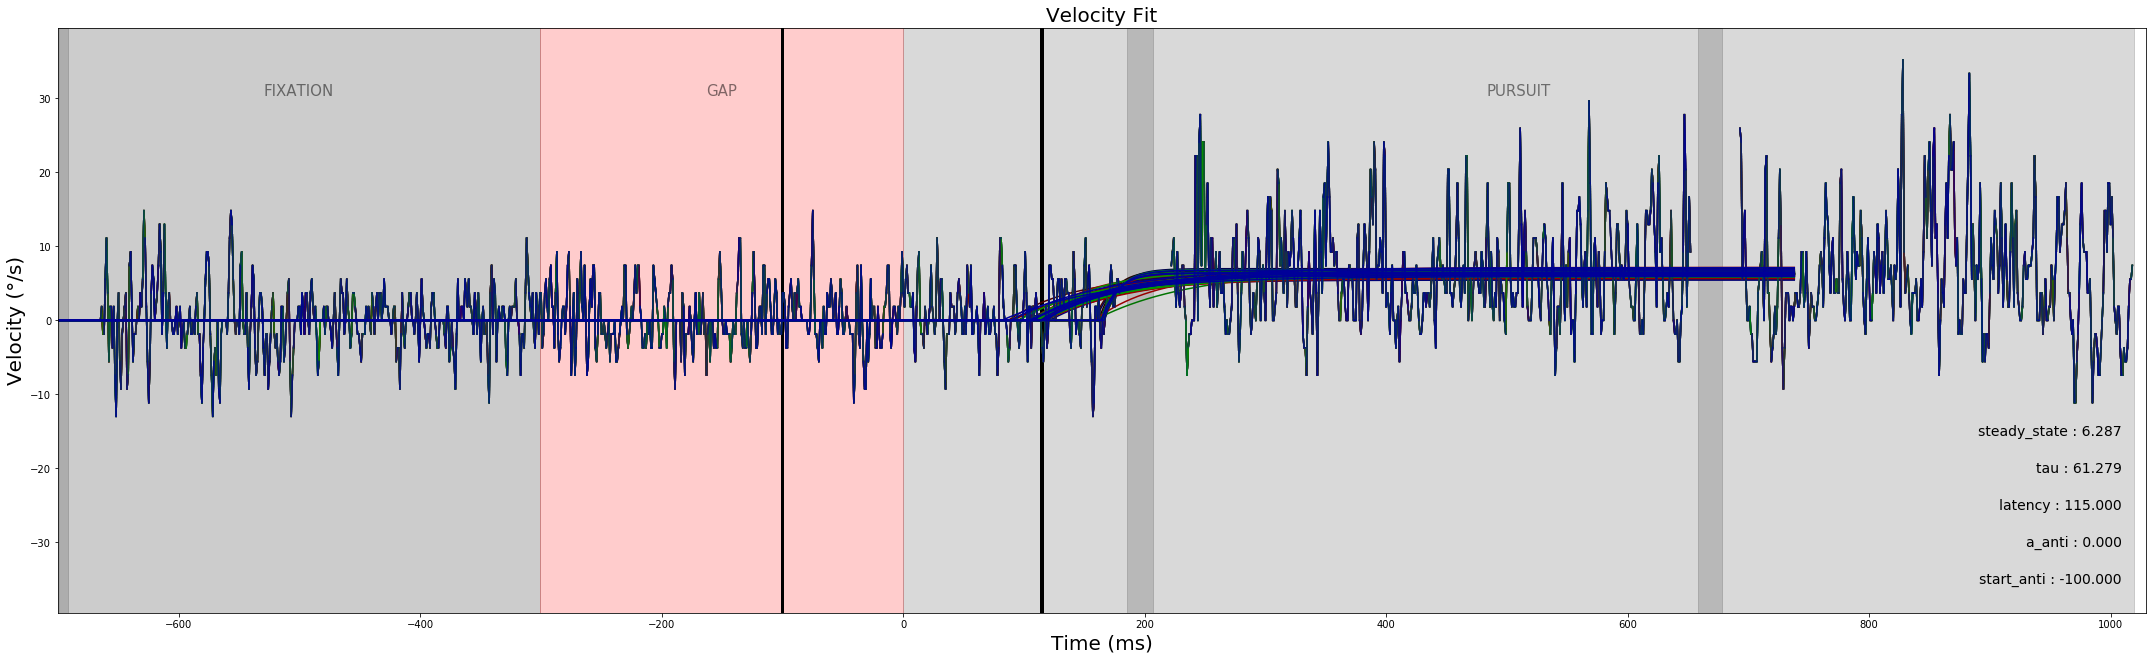

In [6]:
s, t = 1, 11
result_full_data_s1, result_red_data_s1 = moulti_fit(s, t)

Good Trial


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


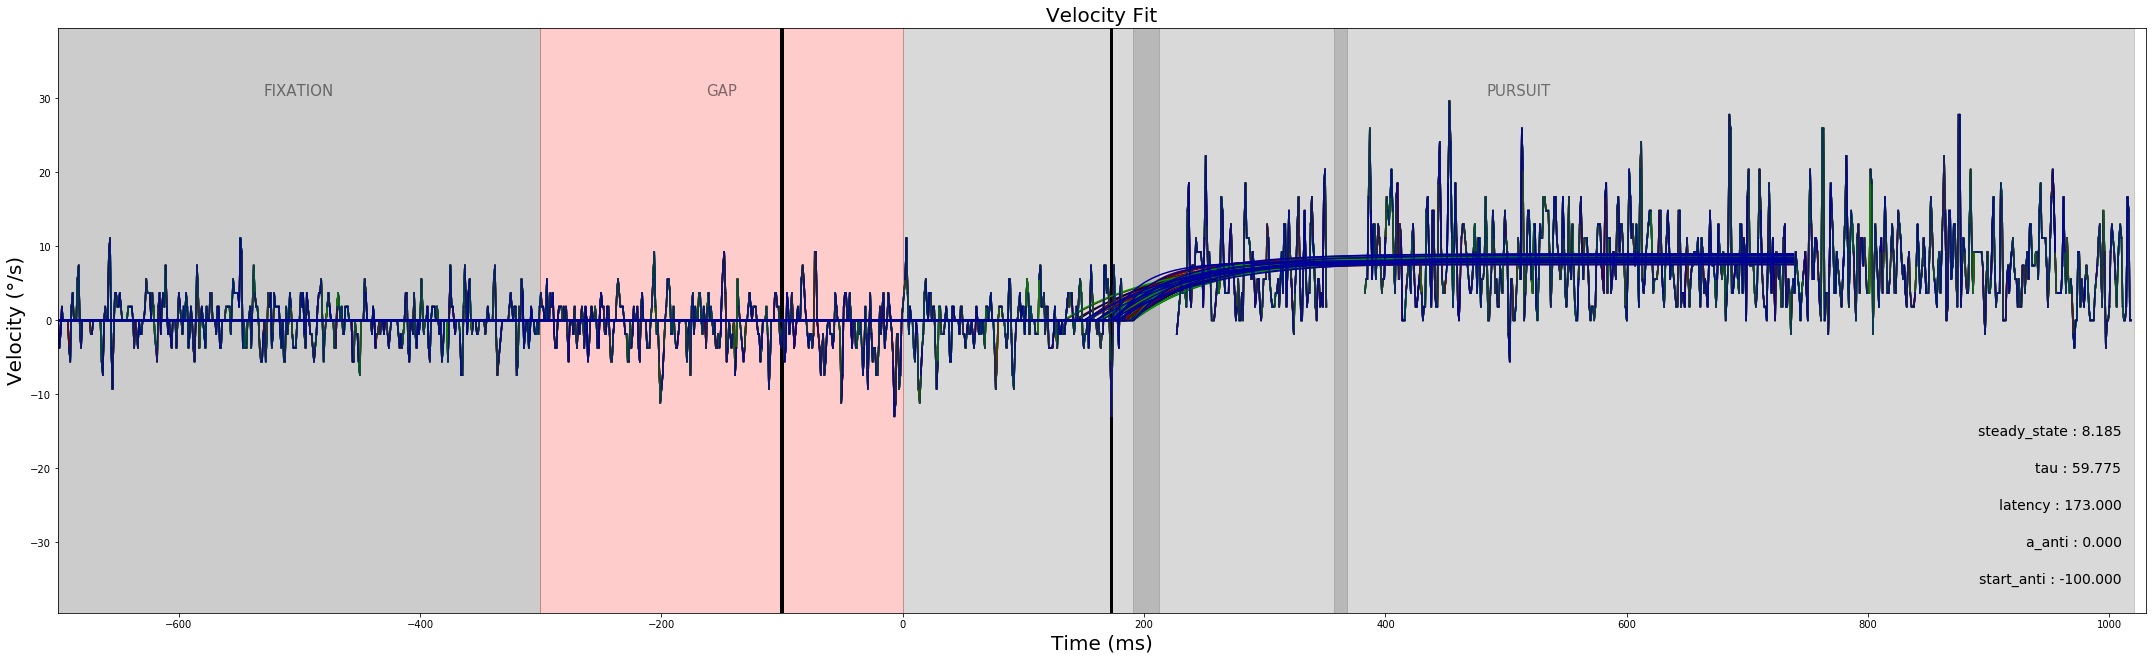

In [7]:
s, t = 2, 11
result_full_data_s2, result_red_data_s2 = moulti_fit(s, t)

Good Trial


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

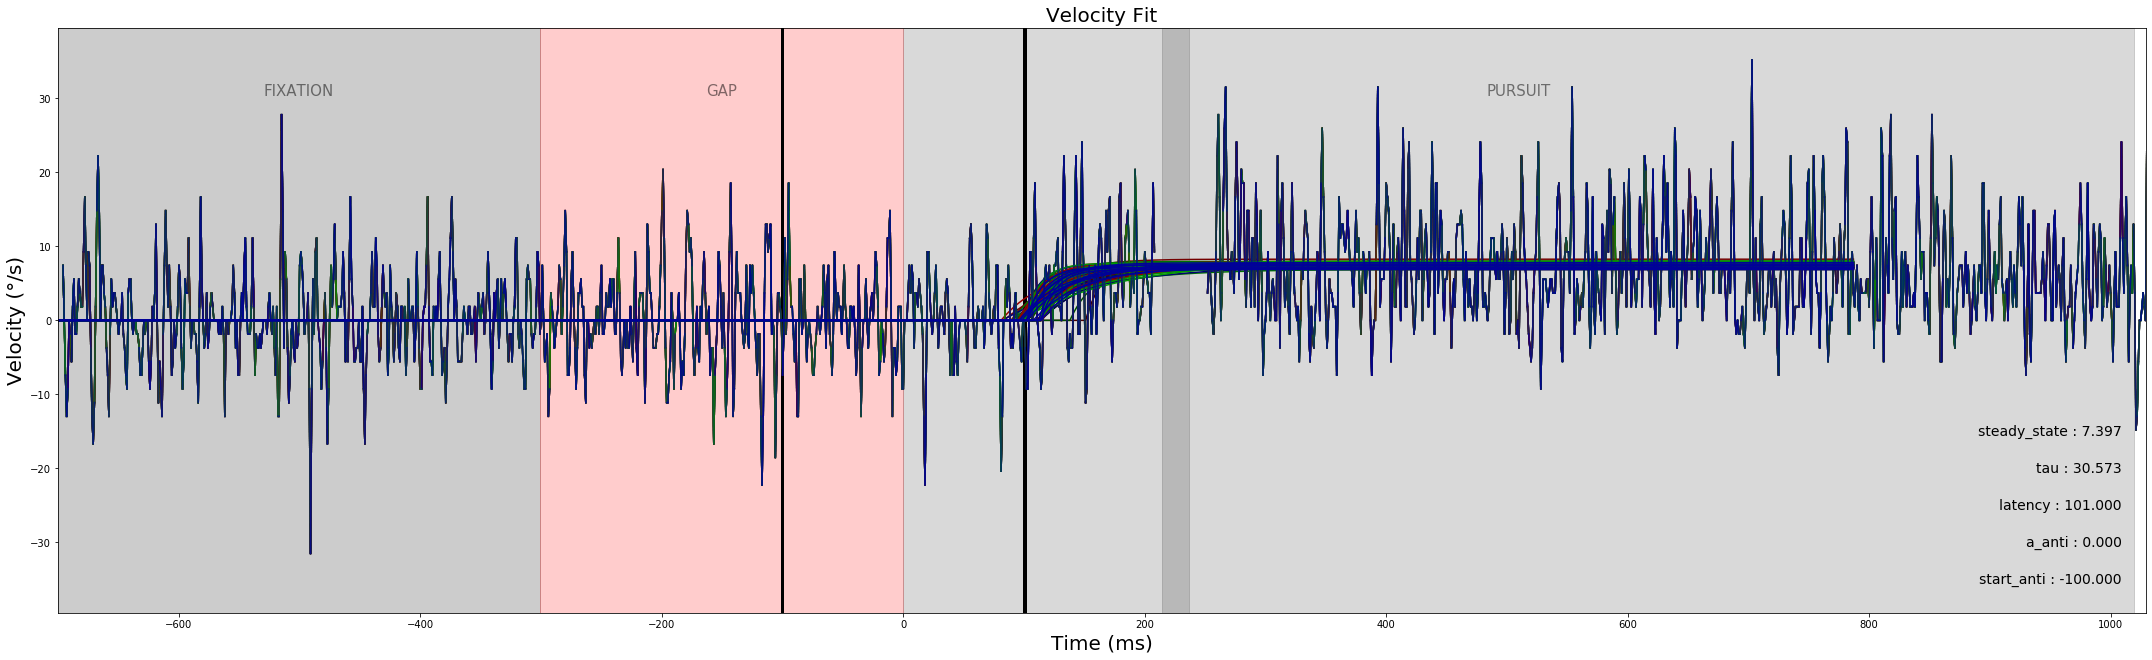

In [8]:
s, t = 3, 11
result_full_data_s3, result_red_data_s3 = moulti_fit(s, t)

Good Trial


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

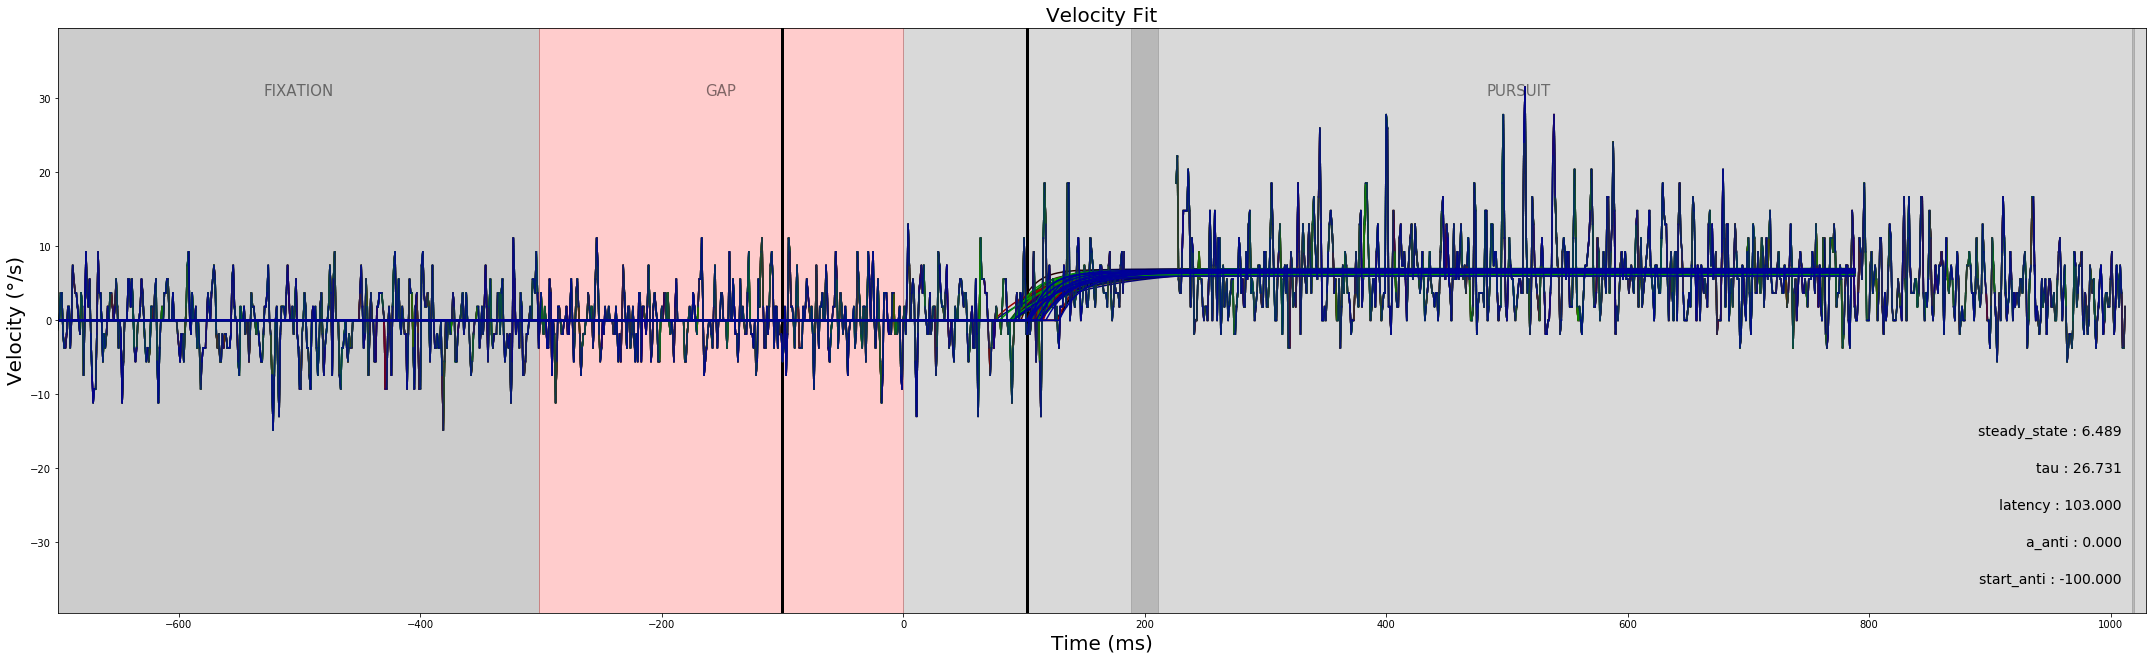

In [9]:
s, t = 4, 11
result_full_data_s4, result_red_data_s4 = moulti_fit(s, t)

# Bad

Bad Trial


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


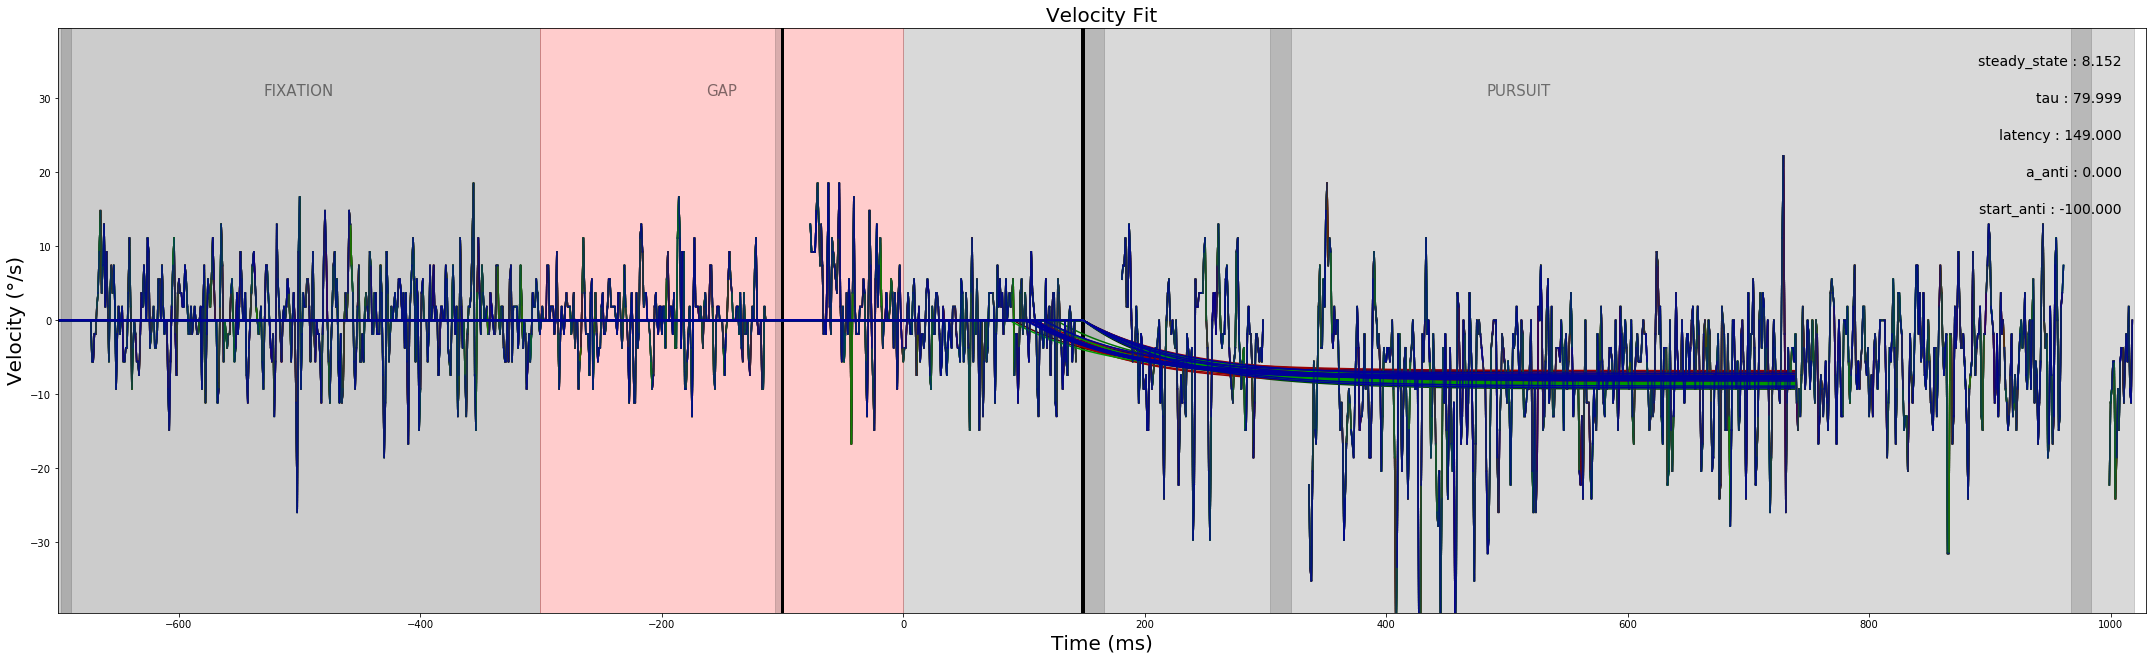

In [10]:
s, t = 1, 392
result_full_data_s1_392, result_red_data_s1_392 = moulti_fit(s, t)

Bad Trial


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

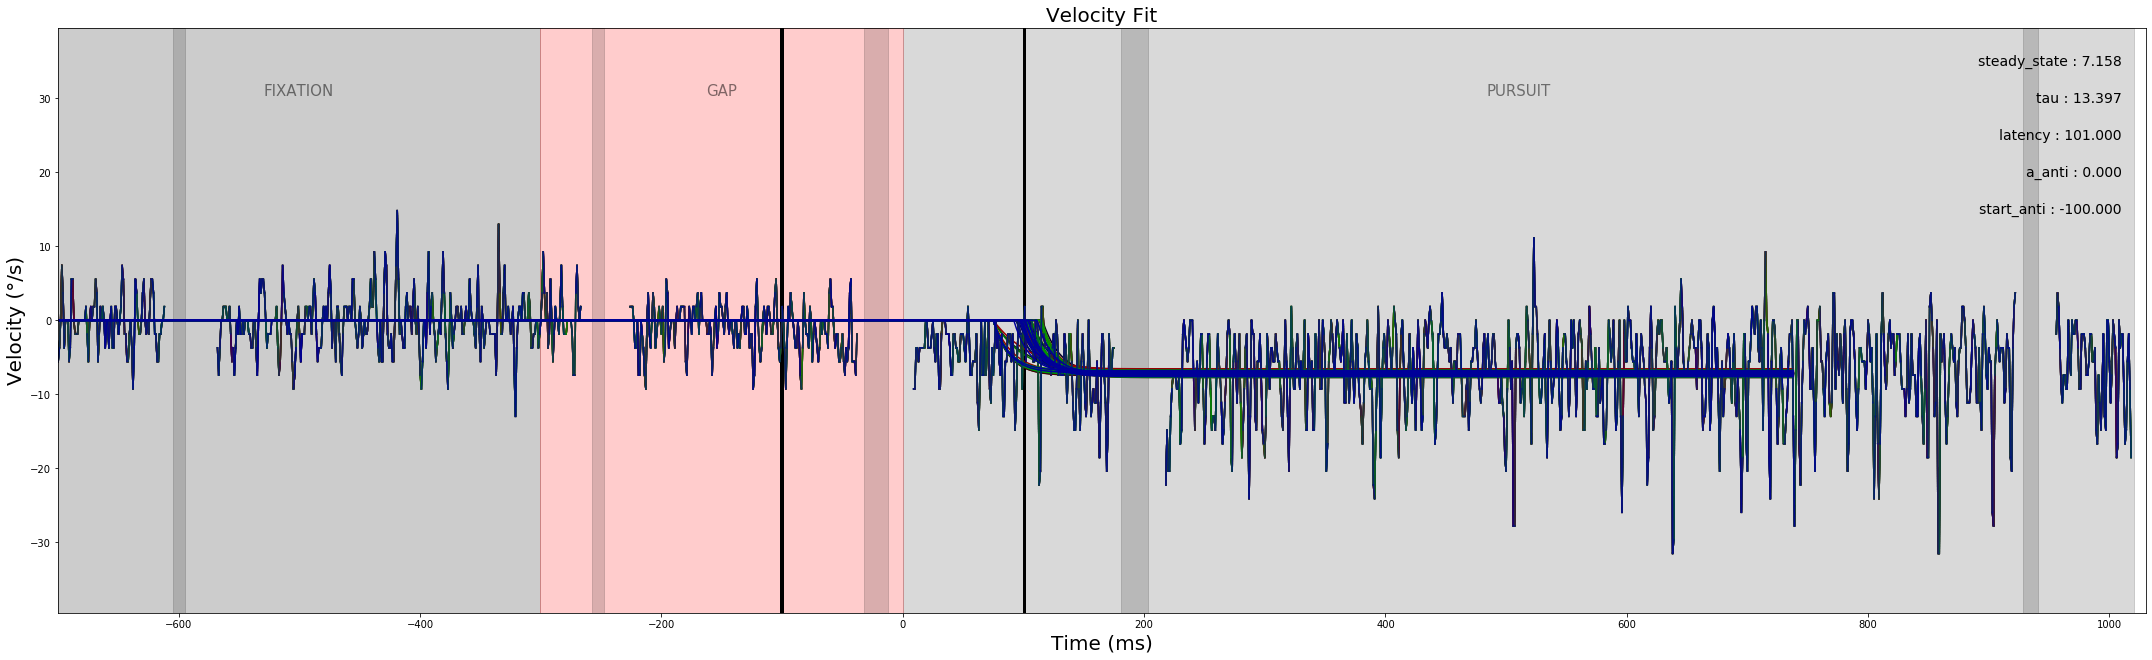

In [11]:
s, t = 2, 57
result_full_data_s2_57, result_red_data_s2_57 = moulti_fit(s, t)

Bad Trial


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


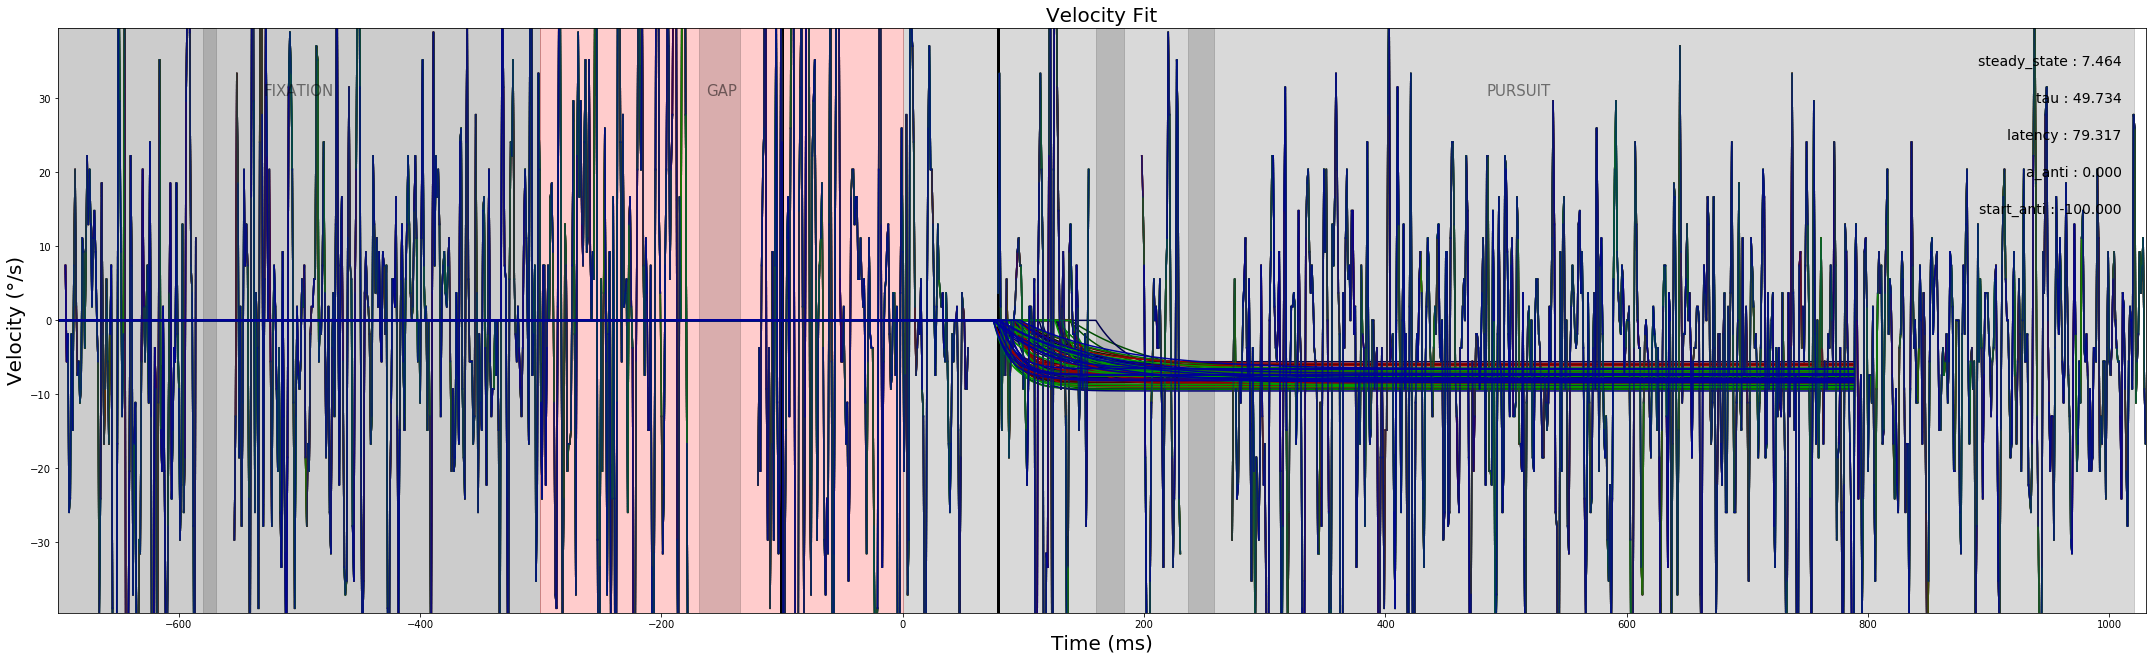

In [12]:
s, t = 3, 72
result_full_data_s3_72, result_red_data_s3_72 = moulti_fit(s, t)

Bad Trial


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


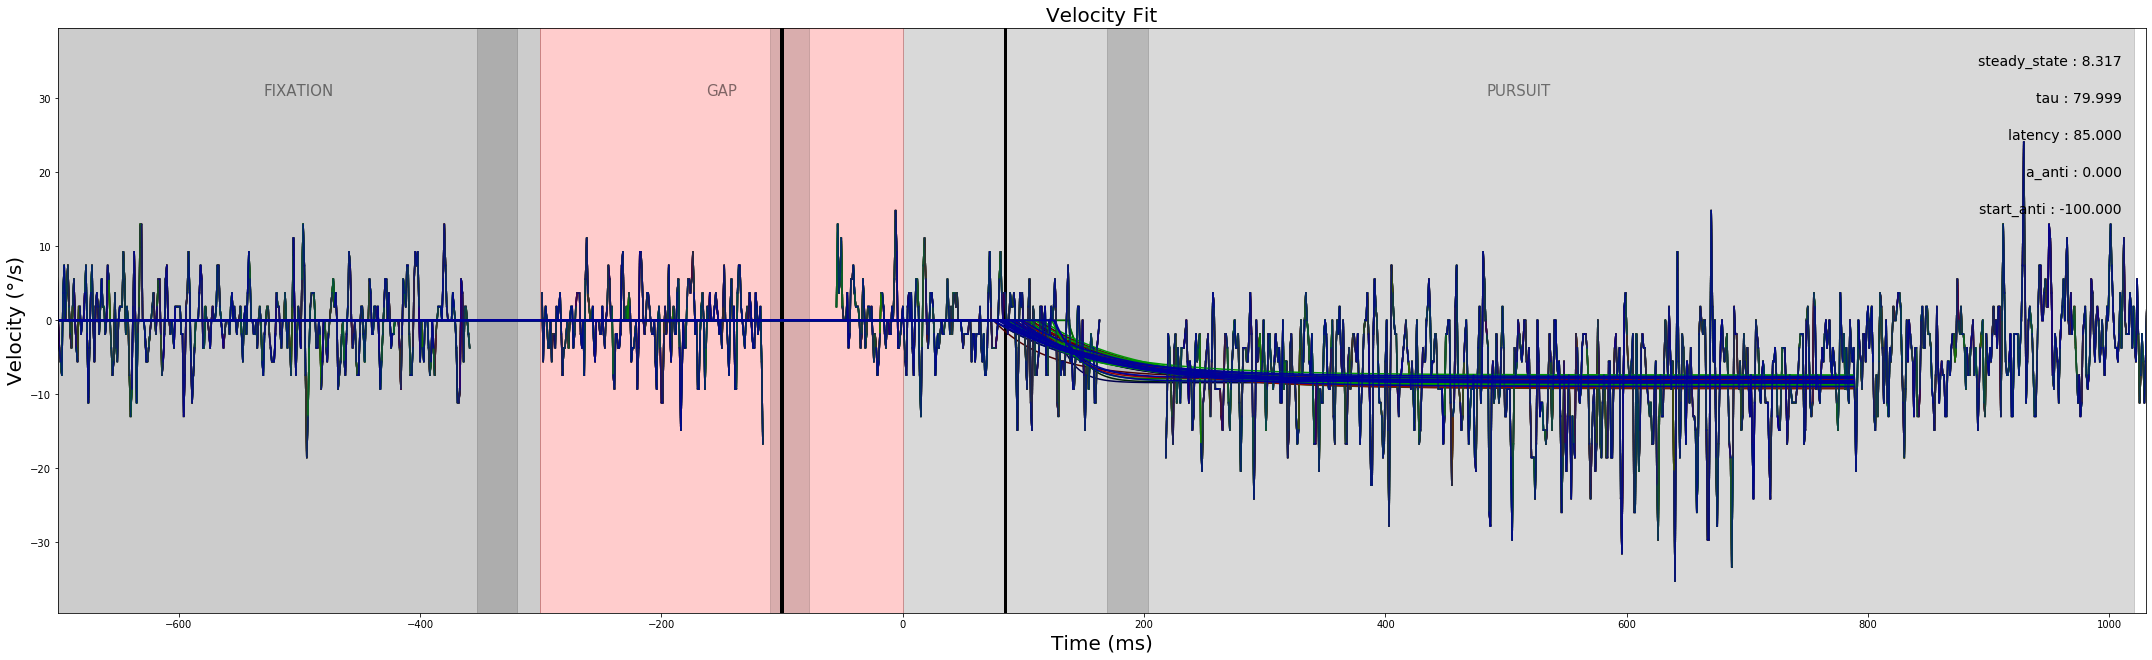

In [13]:
s, t = 4, 340
result_full_data_s4_340, result_red_data_s4_340 = moulti_fit(s, t)

# Hist

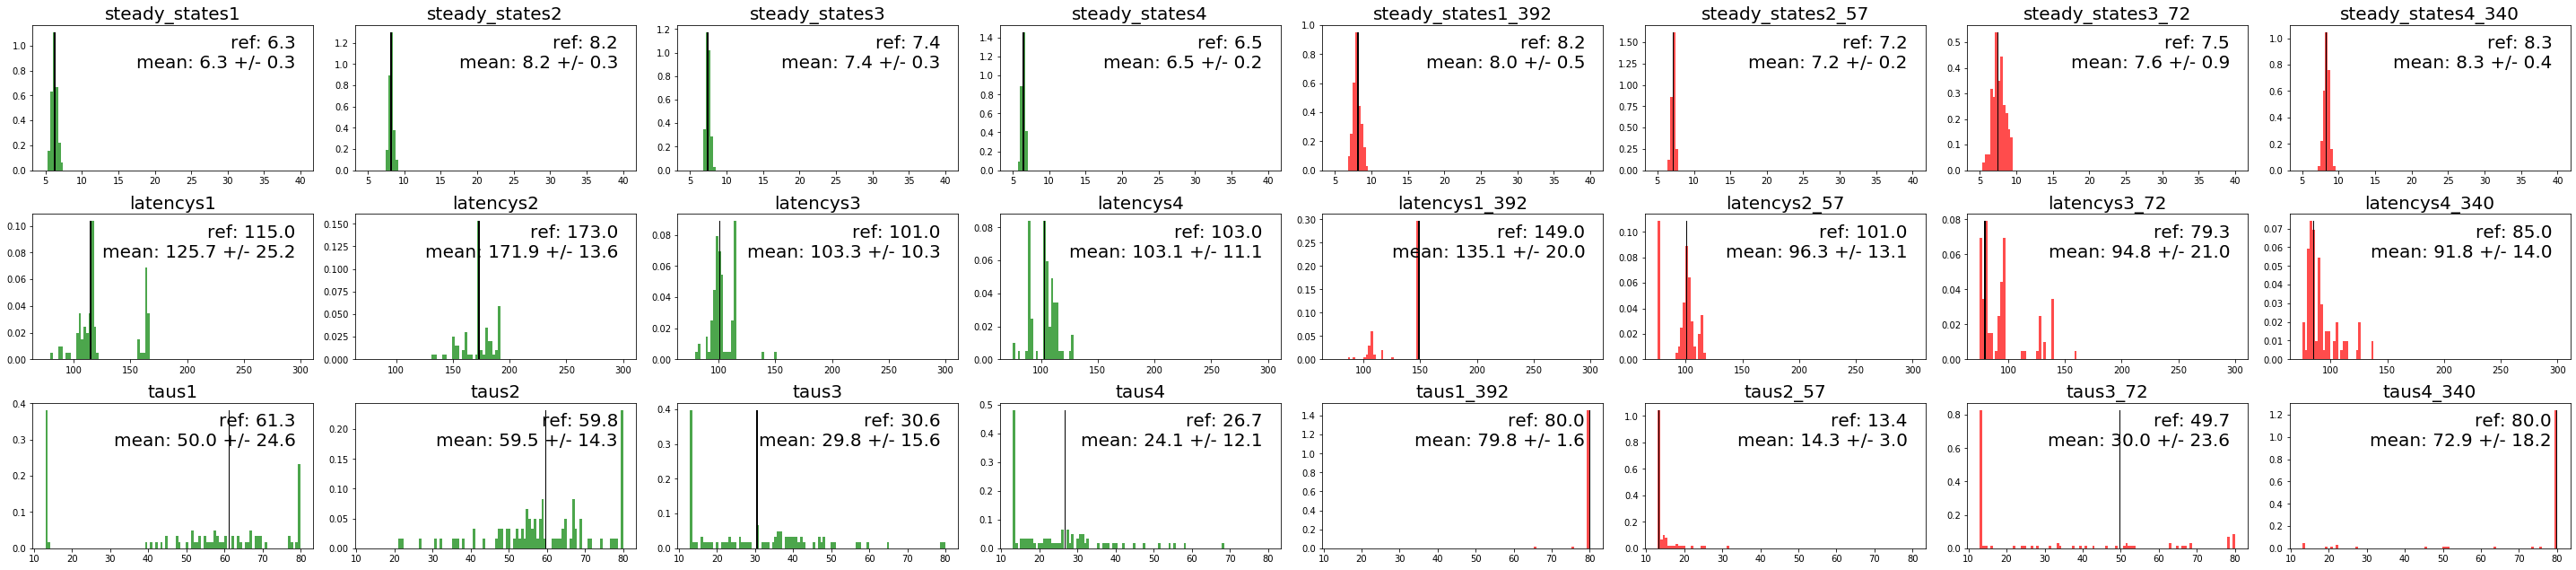

In [14]:
histoto([result_full_data_s1, result_full_data_s2, result_full_data_s3, result_full_data_s4,
         result_full_data_s1_392, result_full_data_s2_57, result_full_data_s3_72, result_full_data_s4_340],
        [result_red_data_s1, result_red_data_s2, result_red_data_s3, result_red_data_s4,
         result_red_data_s1_392, result_red_data_s2_57, result_red_data_s3_72, result_red_data_s4_340],
        ['s1', 's2', 's3', 's4', 's1_392', 's2_57', 's3_72', 's4_340'],
        [ 'g',  'g',  'g',  'g',    'r',      'r',     'r',     'r'], bins=100)